<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/rice-quality-classification/blob/master/klasifikasi_kualitas_beras_mobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Kualitas Beras (mobileNet)**

---

Import dataset dari github

In [1]:
!apt-get install subversion > /dev/null
!svn export https://github.com/Soedirman-Machine-Learning/rice-quality-classification/trunk/dataset_n > /dev/null

Import library

In [2]:
from __future__ import absolute_import, print_function, division, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import math, os, sys
import itertools
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd


import dataset

In [3]:
!ls dataset_n/
!ls dataset_n/train/ir64/
!ls dataset_n/train/ir64/medium/
!ls dataset_n/train/ir64/premium/
!ls dataset_n/train/ir64/tidak_layak/

test  train
medium	premium  tidak_layak
mi_001.jpg  mi_015.jpg	mi_029.jpg  mi_043.jpg	mi_057.jpg  mi_071.jpg
mi_002.jpg  mi_016.jpg	mi_030.jpg  mi_044.jpg	mi_058.jpg  mi_072.jpg
mi_003.jpg  mi_017.jpg	mi_031.jpg  mi_045.jpg	mi_059.jpg  mi_073.jpg
mi_004.jpg  mi_018.jpg	mi_032.jpg  mi_046.jpg	mi_060.jpg  mi_074.jpg
mi_005.jpg  mi_019.jpg	mi_033.jpg  mi_047.jpg	mi_061.jpg  mi_075.jpg
mi_006.jpg  mi_020.jpg	mi_034.jpg  mi_048.jpg	mi_062.jpg  mi_076.jpg
mi_007.jpg  mi_021.jpg	mi_035.jpg  mi_049.jpg	mi_063.jpg  mi_077.jpg
mi_008.jpg  mi_022.jpg	mi_036.jpg  mi_050.jpg	mi_064.jpg  mi_078.jpg
mi_009.jpg  mi_023.jpg	mi_037.jpg  mi_051.jpg	mi_065.jpg  mi_079.jpg
mi_010.jpg  mi_024.jpg	mi_038.jpg  mi_052.jpg	mi_066.jpg  mi_080.jpg
mi_011.jpg  mi_025.jpg	mi_039.jpg  mi_053.jpg	mi_067.jpg
mi_012.jpg  mi_026.jpg	mi_040.jpg  mi_054.jpg	mi_068.jpg
mi_013.jpg  mi_027.jpg	mi_041.jpg  mi_055.jpg	mi_069.jpg
mi_014.jpg  mi_028.jpg	mi_042.jpg  mi_056.jpg	mi_070.jpg
pi_001.jpg  pi_015.jpg	pi_029.jpg  pi_043.

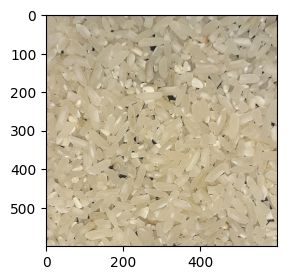

In [4]:
image =imread("dataset_n/train/ir64/medium/mi_019.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [5]:
#membuat dataset pelatihan
image_size=224
batch_size=32
base_dir=os.path.join('dataset_n/train/ir64')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen=datagen.flow_from_directory(
    base_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    subset='training'
)

val_gen=datagen.flow_from_directory(
    base_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    subset="validation"
)

#membuat dataset pengujian
X_test = []
y_test = []
labels = ['medium', 'premium', 'tidak_layak']

for i,label in enumerate(labels):
    folder = os.path.join("dataset_n/test/ir64",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_gen:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_gen:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (32, 224, 224, 3) (32, 3)
Bentuk array dari dataset validation (validasi) adalah: (32, 224, 224, 3) (32, 3)
Bentuk array dari dataset test (pengujian) adalah: (60, 224, 224, 3) (60,)


In [6]:
print (train_gen.class_indices)

labels_txt = '\n'.join(sorted(train_gen.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)
  

{'medium': 0, 'premium': 1, 'tidak_layak': 2}


In [7]:
!cat labels.txt

medium
premium
tidak_layak

In [8]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

17227776/17225924 [==============================] - 0s 0us/step


In [9]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [10]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [11]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [12]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


Pelatihan

In [13]:
history = model.fit_generator(train_gen, 
                    epochs=100, 
                    validation_data=val_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
6/6 [==============================] - 2s 375ms/step - loss: 3.1477 - acc: 0.3958 - val_loss: 1.4093 - val_acc: 0.6250
Epoch 2/100
6/6 [==============================] - 2s 262ms/step - loss: 0.7616 - acc: 0.5885 - val_loss: 0.6369 - val_acc: 0.8750
Epoch 3/100
6/6 [==============================] - 2s 270ms/step - loss: 0.5310 - acc: 0.8854 - val_loss: 0.7646 - val_acc: 0.7708
Epoch 4/100
6/6 [==============================] - 2s 267ms/step - loss: 0.4354 - acc: 0.8854 - val_loss: 0.4651 - val_acc: 0.8958
Epoch 5/100
6/6 [==============================] - 2s 270ms/step - loss: 0.3809 - acc: 0.8073 - val_loss: 0.4868 - val_acc: 0.8125
Epoch 6/100
6/6 [==============================] - 2s 268ms/step - loss: 0.2914 - acc: 0.9583 - val_loss: 0.4437 - val_acc: 0.8125
Epoch 7/100
6/6 [==============================] - 2s 268ms/step - loss: 0.2280 - acc: 0.9792 - val_loss: 0.3191 - val_acc: 0.9167
Epoch 8

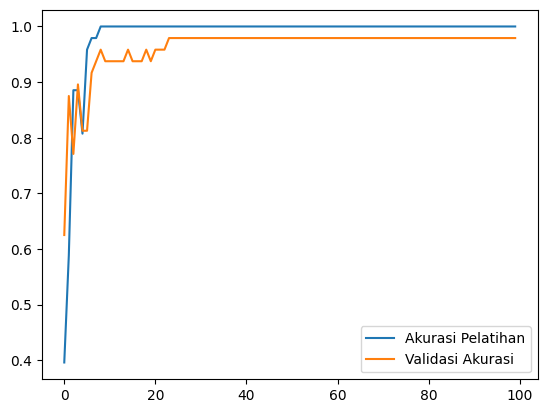

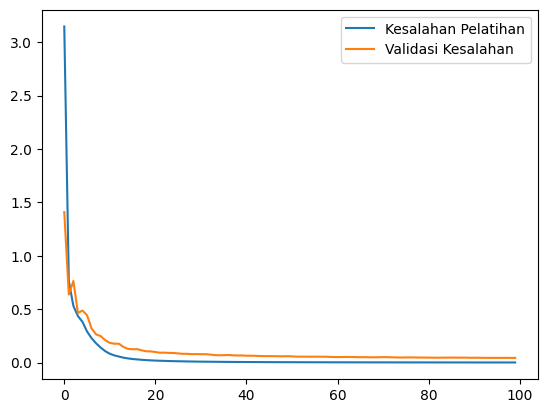

In [14]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [15]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))
print(train_gen)

Number of trainable variables = 4


In [16]:
#Prediksi Label Validasi dengan Pelatihan
n = 14
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [9.9083966e-01 9.1603212e-03 4.6161502e-10]


In [17]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
2/2 [==============================] - 0s 108ms/step - loss: 0.0105 - acc: 1.0000
[0.010532143525779247, 1.0]


In [18]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


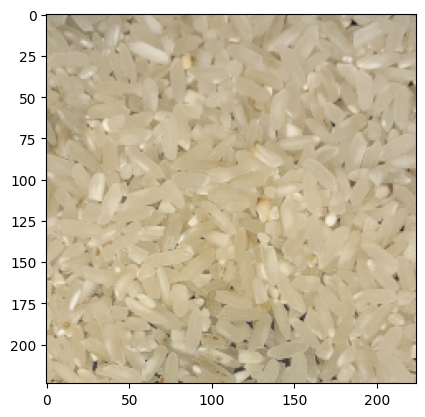

Label yang benar adalah: 0 : medium
Nilai yang diprediksi adalah: [9.9994624e-01 5.3723721e-05 1.6644711e-12]
Label yang diprediksi adalah: 0 : medium
Prediksi benar


In [19]:
n = 14 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


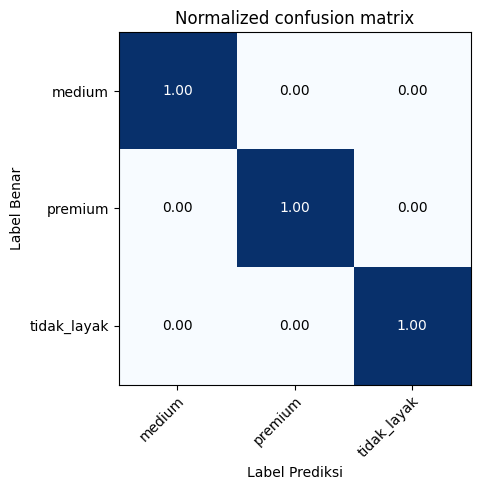

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [21]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_Kualitas_Beras_MobileNet_nf.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
